<a href="https://colab.research.google.com/github/VitaliyYasnitskiy/-/blob/main/DogsBreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Постановка задачи
Определять породу собаки по фотографии. Протестировать полученную модель на отложенной выборке и на аугментированных изображениях.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import albumentations as A
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, ReLU
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy, top_k_categorical_accuracy
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm_notebook
%matplotlib inline

Полные данные можно скачать <a href="https://www.kaggle.com/c/dog-breed-identification">тут </a> или <a href="http://vision.stanford.edu/aditya86/ImageNetDogs/">тут</a>

Мы же воспользуемся небольшой частью

In [ ]:
from google.colab import files
if 'data_sample.zip' not in os.listdir():
  uploaded = files.upload()

Saving data_sample.zip to data_sample.zip


In [ ]:
if 'data_sample' not in os.listdir():
  !unzip data_sample.zip

Archive:  data_sample.zip
   creating: data_sample/
  inflating: data_sample/labels_sample.csv  
   creating: data_sample/test/
  inflating: data_sample/test/0.jpg  
  inflating: data_sample/test/1.jpg  
  inflating: data_sample/test/2.jpg  
  inflating: data_sample/test/3.jpg  
  inflating: data_sample/test/4.jpg  
   creating: data_sample/train/
  inflating: data_sample/train/000bec180eb18c7604dcecc8fe0dba07.jpg  
  inflating: data_sample/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
  inflating: data_sample/train/001cdf01b096e06d78e9e5112d419397.jpg  
  inflating: data_sample/train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
  inflating: data_sample/train/0021f9ceb3235effd7fcde7f7538ed62.jpg  
  inflating: data_sample/train/002211c81b498ef88e1b40b9abf84e1d.jpg  
  inflating: data_sample/train/00290d3e1fdd27226ba27a8ce248ce85.jpg  
  inflating: data_sample/train/002a283a315af96eaea0e28e7163b21b.jpg  
  inflating: data_sample/train/003df8b8a8b05244b1d920bb6cf451f9.jpg  
  inflating: data_sa

### 1. Используемые библиотеки
- `numpy` - работа с многомерными массивами
- `pandas` - считывание и обработка `.csv` файлов
- `matplotlib` - вывод изображений
- `tensorflow/keras` - фреймворк для создания и обучения нейросетей
- `albumentations` - фреймворк для создания аугментированных изображений
- `tqdm` - прогресс-бар

[<img src="https://habrastorage.org/webt/wz/o5/gm/wzo5gmjyybfdr1ea_lwtrhsjzvw.jpeg">](https://keras.io/)

In [ ]:
# КОНФИГУРАЦИОННЫЕ ПАРАМЕТРЫ
IMG_SHAPE = (224, 224)
NUM_BREEDS = 120
TRAIN_SIZE = 480

### Считывание изображений

In [ ]:
def read_img(img_id, size, train=True):
    if train:
        img = image.load_img(f'./data_sample/train/{img_id}.jpg', target_size=size)
    else:
        img = image.load_img(f'./data_sample/test/{img_id}.jpg', target_size=size)
    img = image.img_to_array(img)
    return img

In [ ]:
labels = pd.read_csv('./data_sample/labels_sample.csv')

breed_to_idx = dict()
idx_to_breed = []
for idx, breed in enumerate(set(labels.breed)):
    idx_to_breed.append(breed)
    breed_to_idx[breed] = idx

assert len(idx_to_breed) == NUM_BREEDS, 'Количество классов не равно ожидаемому'

Порода - saint_bernard


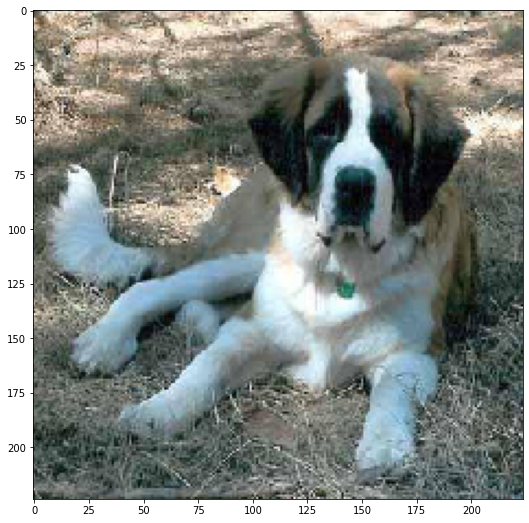

In [ ]:
# посмотрим на случайное изображение
t = np.random.randint(labels.shape[0])
img = read_img(labels.id[t], IMG_SHAPE)
print(f'Порода - {labels.breed[t]}')
plt.figure(figsize=(9, 9))
plt.imshow(img / 255);

In [ ]:
def load_images(target_size=IMG_SHAPE, max_read=None):
    X = []
    y = []
    if not max_read:
        max_read = labels.shape[0]
    for _, (imageid, breed) in tqdm_notebook(labels[:max_read].iterrows(), total=max_read):
        img = read_img(imageid, target_size)
        X.append(img)
        y.append(breed_to_idx[breed])
    return np.array(X), np.array(y)

In [ ]:
X, y = load_images(max_read=TRAIN_SIZE) # считываем TRAIN_SIZE изображений
X_train = preprocess_input(X)  # Стандартизация изображений
y_train = to_categorical(y, num_classes=NUM_BREEDS)  # Преобразование в one-hot вектор

print(f'Размер обучающих изображений = {X_train.shape}')
print(f'Размер обучающей разметки = {y_train.shape}')

del X, y  # Освобождаем память


Размер обучающих изображений = (480, 224, 224, 3)
Размер обучающей разметки = (480, 120)


### Архитектура нейросети

Воспользуемся архитектурой [MobileNetV2]("https://arxiv.org/abs/1801.04381")

Особенности:
 - Маленький размер
 - Новые формы блоков
 - Функция активации ReLU6 (Авторы утверждают, что нейросеть с такой функцией активации удобнее сжимать для использования в мобильных девайсах)

 [<img src="https://paperswithcode.com/media/methods/ReLU61_jm4UDCx.png">]()

### Построение нейросети

In [ ]:
# Скачаем предобученную модель, удалив из неё последний слой
base_model = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Чтобы быстрее обучаться, обучим "голову" отдельно
# для этого пропустим картинки через предобученную сеть и используем их
# как входные данные для "головы"
X_train_embeddings = base_model.predict(X_train)
del X_train

print(f'Размерность после выхода из базовой сети = {X_train_embeddings.shape}')

NameError: ignored

In [ ]:
# Создадим голову нашей сети, которую мы будем обучать
head_input = Input(shape=(7, 7, 1280))
x = GlobalAveragePooling2D()(head_input)
x = Dense(units=128, activation=ReLU(max_value=6))(x)
outputs = Dense(NUM_BREEDS, activation='softmax')(x)

head_model = Model(inputs=head_input, outputs=outputs)
head_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 7, 1280)]      0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 120)               15480     
Total params: 179,448
Trainable params: 179,448
Non-trainable params: 0
_________________________________________________________________


### Обучение

In [ ]:
head_model.compile(
    optimizer='nadam',  # Adam + Nesterov momentum
    loss='categorical_crossentropy', 
    metrics=['accuracy', TopKCategoricalAccuracy(k=2)]
)

head_model.fit(X_train_embeddings, y_train, batch_size=64, epochs=5)

NameError: ignored

In [ ]:
# Соединим базовую модель и голову
base_out = base_model.output

full_out = head_model(base_out)
model = Model(inputs=base_model.input, outputs=full_out)

del X_train_embeddings, y_train

NameError: ignored

#### Тестирование в "интерактивном" режиме

pug - 0.068
boxer - 0.048
bull_mastiff - 0.030


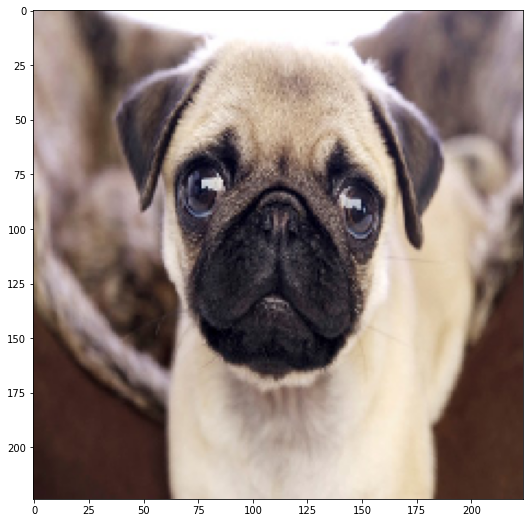

In [ ]:
img = read_img('1', size=IMG_SHAPE, train=False)

plt.figure(figsize=(9, 9))
plt.imshow(img / 255);

img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

preds = model.predict(img)[0]

for dog_idx in preds.argsort()[-1:-4:-1]:
    breed = idx_to_breed[dog_idx]
    pr = preds[dog_idx]
    print(f'{breed} - {pr:.3f}')

### 6. Тестирование на отложенной выборке
Возьмем последние N - TRAIN_SIZE изображений в датасете и посчитаем на них метрики

In [ ]:
num_last = 120
X_test = []
y_test = []
for _, (imageid, breed) in tqdm_notebook(labels[-num_last:].iterrows(), total=num_last):
    img = read_img(imageid, IMG_SHAPE)
    X_test.append(img)
    y_test.append(breed_to_idx[breed])
X_test = preprocess_input(np.array(X_test))
y_test = to_categorical(np.array(y_test))

In [ ]:
probs = model.predict(X_test)

In [ ]:
top3_acc = top_k_categorical_accuracy(y_test, probs, k=3).numpy()
print(f'На тестовой выборке\nTop-3 accuracy: {top3_acc.sum() / top3_acc.shape[0]}')

top1_acc = top_k_categorical_accuracy(y_test, probs, k=1).numpy()
print(f'На тестовой выборке\nTop-1 accuracy: {top1_acc.sum() / top1_acc.shape[0]}')

На тестовой выборке
Top-3 accuracy: 0.2916666666666667
На тестовой выборке
Top-1 accuracy: 0.16666666666666666


### Тестирование с аугментациями

In [ ]:
def read_img(img_id, size, train=True, transform=None):
    if train:
        img = image.load_img(f'./data_sample/train/{img_id}.jpg', target_size=size)
    else:
        img = image.load_img(f'./data_sample/test/{img_id}.jpg', target_size=size)
    img = image.img_to_array(img, dtype=np.uint8)
    if transform is not None:
        img = transform(image=img, )['image']
    return img

In [ ]:
augmentations = [
    A.NoOp(always_apply=True),
    # A.GaussianBlur(blur_limit=(5, 9), always_apply=True),
    A.GaussNoise(always_apply=True), # old version
    A.MedianBlur(blur_limit=9, always_apply=True),
    A.RGBShift(always_apply=True),
    A.HueSaturationValue(always_apply=True),
    A.ChannelShuffle(always_apply=True),
    A.CLAHE(always_apply=True),
    A.RandomContrast(always_apply=True),
    A.RandomBrightness(always_apply=True),
    A.ToGray(always_apply=True),
    A.JpegCompression(quality_lower=20, quality_upper=20, always_apply=True),
    A.ElasticTransform(always_apply=True)
]
aug_names = ['Оригинальное изображение', "Гауссовское размытие",
             'Медианное размытие', 'RGB-сдвиг',
             'HSV-сдвиг', 'Перемешивание каналов',
             'CLAHE', 'Изменение контраста',
             'Изменения яркости', 'Оттенки серого',
             'JPEG-сжатие', 'Эластичная трансформация', 
            ]
print(len(augmentations))

12


In [ ]:
img_examples = []
transforms_accuracy = []

num_img_display = 12
num_last = 120
for transform in tqdm_notebook(augmentations):
    X_test = []
    y_test = []
    for _, (imageid, breed) in labels[-num_last:].iterrows():
        img = read_img(imageid, IMG_SHAPE, transform=transform)
        X_test.append(img)
        y_test.append(breed_to_idx[breed])
    img_examples.append(X_test[num_img_display])
    X_test = preprocess_input(np.array(X_test))
    y_test = to_categorical(np.array(y_test))

    probs = model.predict(X_test)
    top1_acc = top_k_categorical_accuracy(y_test, probs, k=1).numpy()
    transforms_accuracy.append(top1_acc.sum() / top1_acc.shape[0])

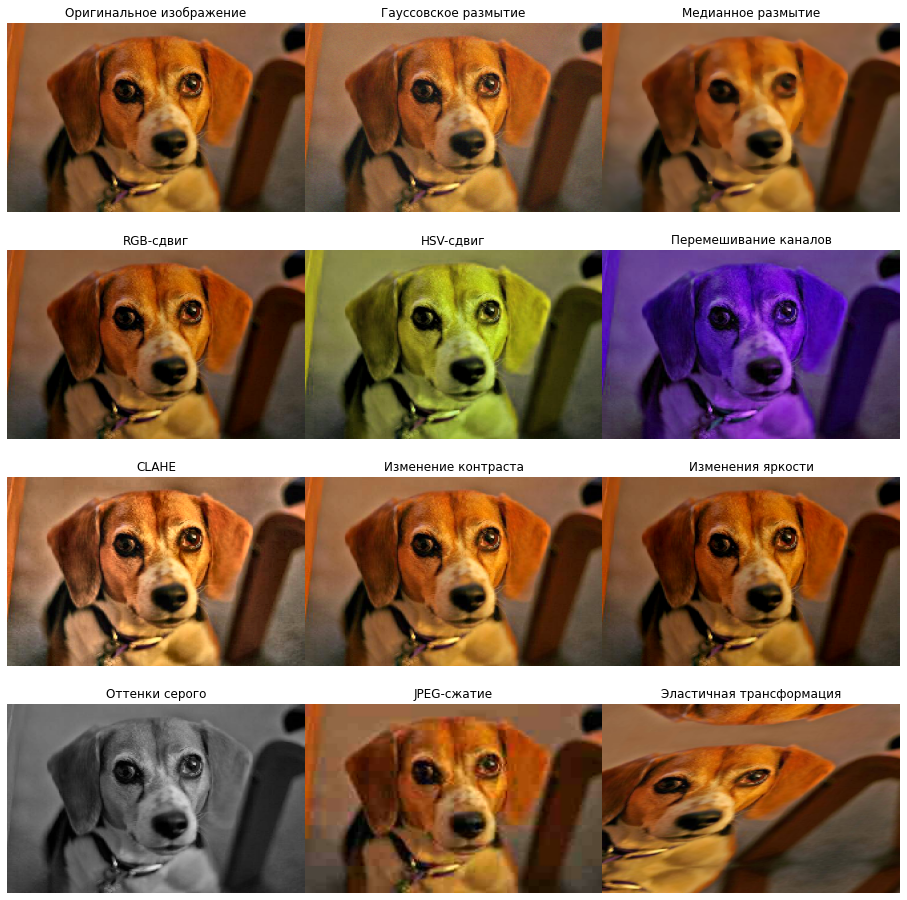

In [ ]:
f, ax = plt.subplots(4, 3, figsize=(16, 16))
for row in range(4):
    for col in range(3):
        ax[row, col].imshow(img_examples[col + row * 3], aspect='auto')
        ax[row, col].axis('off')
        ax[row, col].set_title(aug_names[col + row * 3])
plt.subplots_adjust(wspace=0, hspace=.2)
plt.savefig('augmentations.png', bbox_inches='tight')
plt.show()

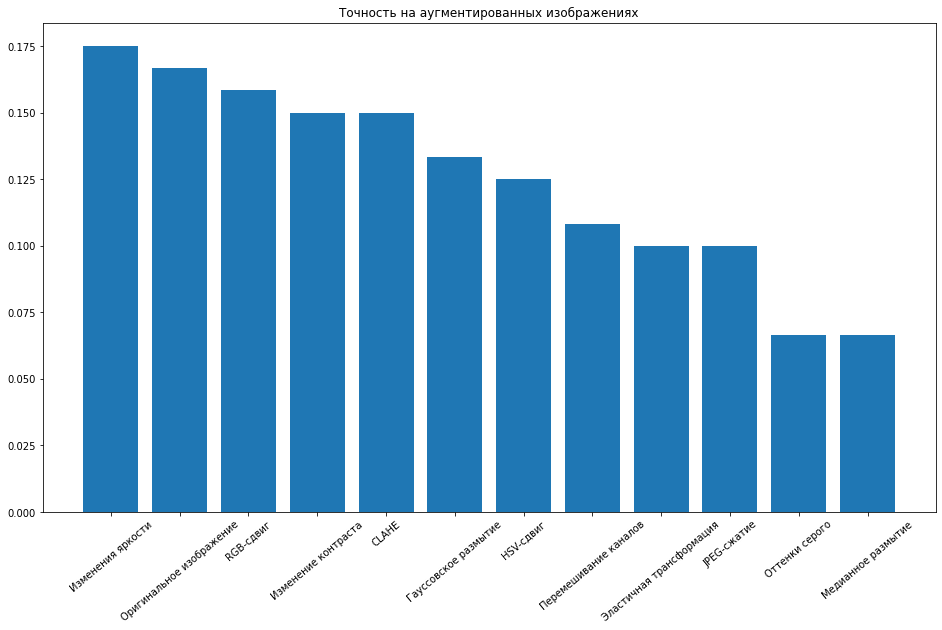

In [ ]:
order = np.argsort(transforms_accuracy)[::-1]
plt.figure(figsize=(16, 9))
plt.xticks(rotation=40)
plt.title('Точность на аугментированных изображениях')
plt.bar(np.array(aug_names)[order], np.array(transforms_accuracy)[order])
plt.savefig('aug_accuracy.png', bbox_inches='tight')
plt.show()